In [4]:
import base64
import io
import pickle
import numpy as np
import torch
print(f'TORCH VERSION: {torch.__version__}')
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'):
  raise RuntimeError('Torch versions lower than 1.5.0 not supported')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

TORCH VERSION: 1.11.0+cu113


In [7]:
if torch.cuda.is_available():
  torch_device = 'cuda'
  float_dtype = np.float32 # single
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
  torch_device = 'cpu'
  float_dtype = np.float64 # double
  torch.set_default_tensor_type(torch.DoubleTensor)
  print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cpu


Often we want to detach tensors from the computational graph and pull them to the CPU as a numpy
array.

In [9]:
def torch_mod(x):
  return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
  return torch_mod(x+np.pi) - np.p

Often we want to detach tensors from the computational graph and pull them to the CPU as a numpy
array.

In [11]:
def grab(var):
  return var.detach().cpu().numpy()

The code below makes a live-updating plot during training.

In [13]:
from IPython.display import display
def init_live_plot(dpi=125, figsize=(8,4)):
  fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
  plt.xlim(0, N_era*N_epoch)
  plt.ylim(0, 1)
  ess_line = plt.plot([0],[0], alpha=0.5) # dummy
  plt.grid(False)
  plt.ylabel('ESS')
  ax_loss = ax_ess.twinx()
  loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
  plt.grid(False)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  display_id = display(fig, display_id=True)
  return dict(
    fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
    ess_line=ess_line, loss_line=loss_line,
    display_id=display_id
  )
def moving_average(x, window=10):
  if len(x) < window:
    return np.mean(x, keepdims=True)
  else:
    return np.convolve(x, np.ones(window), 'valid') / window

def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
  Y = np.array(history['ess'])
  Y = moving_average(Y, window=15)
  ess_line[0].set_ydata(Y)
  ess_line[0].set_xdata(np.arange(len(Y)))
  Y = history['loss']
  Y = moving_average(Y, window=15)
  loss_line[0].set_ydata(np.array(Y))
  loss_line[0].set_xdata(np.arange(len(Y)))
  ax_loss.relim()
  ax_loss.autoscale_view()
  fig.canvas.draw()
  display_id.update(fig) # need to force colab to update plot

Prior distribution

In [17]:
class SimpleNormal:
  def __init__(self, loc, var):
    self.dist = torch.distributions.normal.Normal(
    torch.flatten(loc), torch.flatten(var))
    self.shape = loc.shape
  def log_prob(self, x):
    logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
    return torch.sum(logp, dim=1)
  def sample_n(self, batch_size):
    x = self.dist.sample((batch_size,))
    return x.reshape(batch_size, *self.shape)

The shape of loc and var determine the shape of samples drawn.

In [18]:
normal_prior = SimpleNormal(torch.zeros((3,4,5)), torch.ones((3,4,5)))
z = normal_prior.sample_n(17)
print(f'z.shape = {z.shape}')
print(f'log r(z) = {grab(normal_prior.log_prob(z))}')

z.shape = torch.Size([17, 3, 4, 5])
log r(z) = [-88.32672344 -83.44440734 -96.11539488 -93.01941914 -86.23947303
 -87.61441515 -90.59617609 -88.99483472 -82.22506002 -89.65476402
 -88.10242312 -80.25365397 -84.51814392 -86.31575877 -77.46228756
 -76.78508889 -78.42059492]


Design coupling layers

In [20]:
class SimpleCouplingLayer(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.s = torch.nn.Sequential(
    torch.nn.Linear(1, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 1),
    torch.nn.Tanh()
    )
  def forward(self, x):
    x1, x2 = x[:,0], x[:,1]
    s = self.s(x2.unsqueeze(-1)).squeeze(-1)
    fx1 = torch.exp(s) * x1
    fx2 = x2
    logJ = s
    return torch.stack((fx1, fx2), dim=-1), logJ
  def reverse(self, fx):
    fx1, fx2 = fx[:,0], fx[:,1]
    x2 = fx2
    s = self.s(x2.unsqueeze(-1)).squeeze(-1)
    logJ = -s
    x1 = torch.exp(-s) * fx1
    return torch.stack((x1, x2), dim=-1), logJ

coupling_layer = SimpleCouplingLayer()

# init weights in a way that gives interesting behavior without training
def set_weights(m):
  if hasattr(m, 'weight') and m.weight is not None:
    torch.nn.init.normal_(m.weight, mean=1, std=2)
  if hasattr(m, 'bias') and m.bias is not None:
    m.bias.data.fill_(-1)
    torch.manual_seed(1234)
    coupling_layer.s.apply(set_weights)

In [55]:
def apply_flow_to_prior(prior, coupling_layers, *, batch_size):
  x = prior.sample_n(batch_size)
  logq = prior.log_prob(x)
  for layer in coupling_layers:
    x, logJ = layer.forward(x)
    logq = logq - logJ
  return x, logq

In [30]:
L = 8
lattice_shape = (L,L)
phi_ex1 = np.random.normal(size=lattice_shape).astype(float_dtype)
phi_ex2 = np.random.normal(size=lattice_shape).astype(float_dtype)
cfgs = torch.from_numpy(np.stack((phi_ex1, phi_ex2), axis=0)).to(torch_device)

In [31]:
class ScalarPhi4Action:
  def __init__(self, M2, lam):
    self.M2 = M2
    self.lam = lam
  def __call__(self, cfgs):
    # potential term
    action_density = self.M2*cfgs**2 + self.lam*cfgs**4
    # kinetic term (discrete Laplacian)
    Nd = len(cfgs.shape)-1
    dims = range(1,Nd+1)
    for mu in dims:
      action_density += 2*cfgs**2
      action_density -= cfgs*torch.roll(cfgs, -1, mu)
      action_density -= cfgs*torch.roll(cfgs, 1, mu)
    return torch.sum(action_density, dim=tuple(dims))
print("Actions for example configs:", ScalarPhi4Action(M2=1.0, lam=1.0)(cfgs))

Actions for example configs: tensor([426.2158, 532.6085])


In [32]:
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

Prior distributions

In [33]:
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

z.shape = (1024, 8, 8)


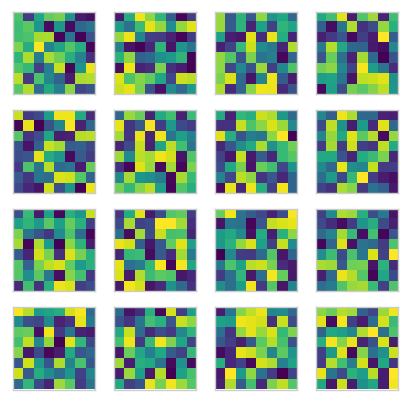

In [34]:
torch_z = prior.sample_n(1024)
z = grab(torch_z)
print(f'z.shape = {z.shape}')
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
  for j in range(4):
    ind = i*4 + j
    ax[i,j].imshow(np.tanh(z[ind]), vmin=-1, vmax=1, cmap='viridis')
    ax[i,j].axes.xaxis.set_visible(False)
    ax[i,j].axes.yaxis.set_visible(False)
plt.show()

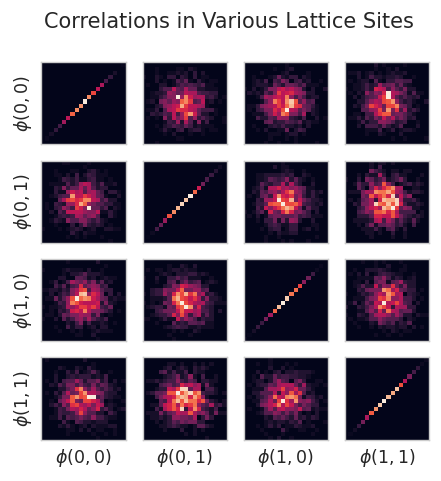

In [37]:
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for x1 in range(2):
  for y1 in range(2):
    i1 = x1*2 + y1
    for x2 in range(2):
      for y2 in range(2):
        i2 = x2*2 + y2
        ax[i1,i2].hist2d(z[:,x1,y1], z[:,x2,y2], range=[[-3,3],[-3,3]], bins=20)
        ax[i1,i2].set_xticks([])
        ax[i1,i2].set_yticks([])
        if i1 == 3:
          ax[i1,i2].set_xlabel(rf'$\phi({x2},{y2})$')
        if i2 == 0:
          ax[i1,i2].set_ylabel(rf'$\phi({x1},{y1})$')
fig.suptitle("Correlations in Various Lattice Sites")
plt.show()

In [38]:
def make_checker_mask(shape, parity):
  checker = torch.ones(shape, dtype=torch.uint8) - parity
  checker[::2, ::2] = parity
  checker[1::2, 1::2] = parity
  return checker.to(torch_device)
print("For example this is the mask for an 8x8 configuration:\n",
make_checker_mask(lattice_shape, 0))

For example this is the mask for an 8x8 configuration:
 tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)


In [39]:
class AffineCoupling(torch.nn.Module):
  def __init__(self, net, *, mask_shape, mask_parity):
    super().__init__()
    self.mask = make_checker_mask(mask_shape, mask_parity)
    self.net = net
  def forward(self, x):
    x_frozen = self.mask * x
    x_active = (1 - self.mask) * x
    net_out = self.net(x_frozen.unsqueeze(1))
    s, t = net_out[:,0], net_out[:,1]
    fx = (1 - self.mask) * t + x_active * torch.exp(s) + x_frozen
    axes = range(1,len(s.size()))
    logJ = torch.sum((1 - self.mask) * s, dim=tuple(axes))
    return fx, logJ
  def reverse(self, fx):
    fx_frozen = self.mask * fx
    fx_active = (1 - self.mask) * fx
    net_out = self.net(fx_frozen.unsqueeze(1))
    s, t = net_out[:,0], net_out[:,1]
    x = (fx_active - (1 - self.mask) * t) * torch.exp(-s) + fx_frozen
    axes = range(1,len(s.size()))
    logJ = torch.sum((1 - self.mask)*(-s), dim=tuple(axes))
    return x, logJ

In [41]:
def make_conv_net(*, hidden_sizes, kernel_size, in_channels, out_channels, use_final_tanh):
  sizes = [in_channels] + hidden_sizes + [out_channels]
  assert packaging.version.parse(torch.__version__) >= packaging.version.parse('1.5.0')
  assert kernel_size % 2 == 1, 'kernel size must be odd for PyTorch >= 1.5.0'
  padding_size = (kernel_size // 2)
  net = []
  for i in range(len(sizes) - 1):
    net.append(torch.nn.Conv2d(
      sizes[i], sizes[i+1], kernel_size, padding=padding_size,
      stride=1, padding_mode='circular'))
    if i != len(sizes) - 2:
      net.append(torch.nn.LeakyReLU())
    else:
      if use_final_tanh:
        net.append(torch.nn.Tanh())
  return torch.nn.Sequential(*net)

Assembling the model

In [42]:
def make_phi4_affine_layers(*, n_layers, lattice_shape, hidden_sizes, kernel_size):
  layers = []
  for i in range(n_layers):
    parity = i % 2
    net = make_conv_net(
      in_channels=1, out_channels=2, hidden_sizes=hidden_sizes,
      kernel_size=kernel_size, use_final_tanh=True)
    coupling = AffineCoupling(net, mask_shape=lattice_shape, mask_parity=parity)
  layers.append(coupling)
  return torch.nn.ModuleList(layers)

In [43]:
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(
lattice_shape=lattice_shape, n_layers=n_layers,
hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}

Training the model

In [44]:
def calc_dkl(logp, logq):
  return (logq - logp).mean() # reverse KL, assuming samples from 

In [47]:
def train_step(model, action, loss_fn, optimizer, metrics):
  layers, prior = model['layers'], model['prior']
  optimizer.zero_grad()
  x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
  logp = -action(x)
  loss = calc_dkl(logp, logq)
  loss.backward()
  optimizer.step()
  metrics['loss'].append(grab(loss))
  metrics['logp'].append(grab(logp))
  metrics['logq'].append(grab(logq))
  metrics['ess'].append(grab( compute_ess(logp, logq) ))

Telemetry

In [48]:
def compute_ess(logp, logq):
  logw = logp - logq
  log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
  ess_per_cfg = torch.exp(log_ess) / len(logw)
  return ess_per_cfg

In [49]:
def print_metrics(history, avg_last_N_epochs):
  print(f'== Era {era} | Epoch {epoch} metrics ==')
  for key, val in history.items():
    avgd = np.mean(val[-avg_last_N_epochs:])
    print(f'\t{key} {avgd:g}')

The training

In [52]:
L = 8
lattice_shape = (L,L)
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)
# Model
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))
19
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(lattice_shape=lattice_shape, n_layers=n_layers,
  hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}
# Training
base_lr = .001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

In [53]:
N_era = 25
N_epoch = 100
batch_size = 64
print_freq = N_epoch
plot_freq = 1
history = {
  'loss' : [],
  'logp' : [],
  'logq' : [],
  'ess' : []
}

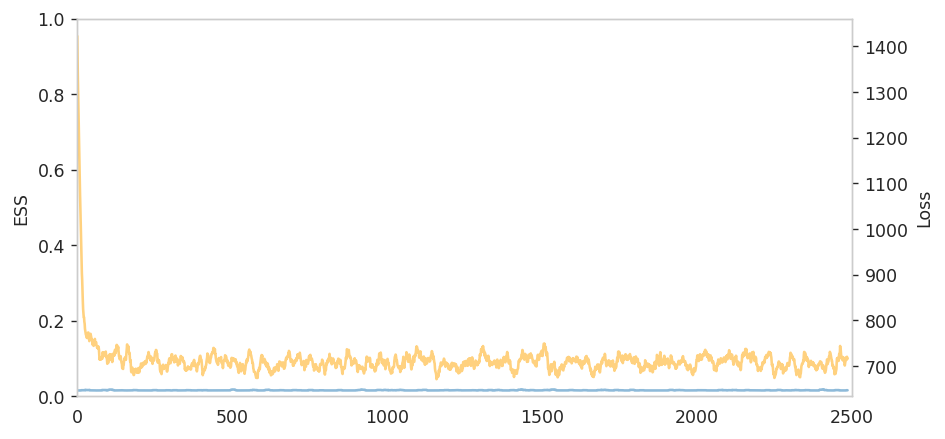

== Era 0 | Epoch 0 metrics ==
	loss 1867.12
	logp -1960.57
	logq -93.4509
	ess 0.015625
== Era 1 | Epoch 0 metrics ==
	loss 861.161
	logp -931.452
	logq -70.2912
	ess 0.0160994
== Era 2 | Epoch 0 metrics ==
	loss 714.273
	logp -775.039
	logq -60.7659
	ess 0.016194
== Era 3 | Epoch 0 metrics ==
	loss 707.367
	logp -766.938
	logq -59.5711
	ess 0.0158566
== Era 4 | Epoch 0 metrics ==
	loss 705.293
	logp -764.444
	logq -59.1507
	ess 0.0158703
== Era 5 | Epoch 0 metrics ==
	loss 713.31
	logp -772.372
	logq -59.0624
	ess 0.0158141
== Era 6 | Epoch 0 metrics ==
	loss 702.875
	logp -761.805
	logq -58.9304
	ess 0.016317
== Era 7 | Epoch 0 metrics ==
	loss 704.812
	logp -763.681
	logq -58.869
	ess 0.0160364
== Era 8 | Epoch 0 metrics ==
	loss 708.523
	logp -767.439
	logq -58.9162
	ess 0.0160297
== Era 9 | Epoch 0 metrics ==
	loss 708.242
	logp -767.202
	logq -58.9605
	ess 0.0157611
== Era 10 | Epoch 0 metrics ==
	loss 703.659
	logp -762.539
	logq -58.8808
	ess 0.016354
== Era 11 | Epoch 0 metric

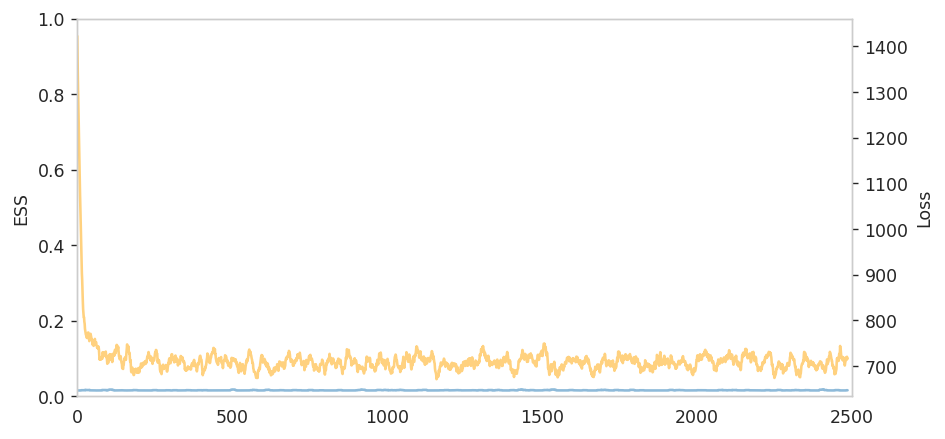

In [56]:
[plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
live_plot = init_live_plot()
for era in range(N_era):
  for epoch in range(N_epoch):
    train_step(model, phi4_action, calc_dkl, optimizer, history)
    if epoch % print_freq == 0:
      print_metrics(history, avg_last_N_epochs=print_freq)
    if epoch % plot_freq == 0:
      update_plots(history, **live_plot)

In [57]:
print('Model weights blob:\n===')
serialized_model = io.BytesIO()
torch.save(model['layers'].state_dict(), serialized_model)
print(base64.b64encode(serialized_model.getbuffer()).decode('utf-8'))
print('===')

Model weights blob:
===
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRG91YmxlU3RvcmFnZQpxBVgBAAAAMHEGWAMAAABjcHVxB0tIdHEIUUsAKEsISwFLA0sDdHEJKEsJSwlLA0sBdHEKiWgAKVJxC3RxDFJxDVgMAAAAMC5uZXQuMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPaAdLCHRxEFFLAEsIhXERSwGFcRKJaAApUnETdHEUUnEVWA4AAAAwLm5ldC4yLndlaWdodHEWaAMoKGgEaAVYAQAAADJxF2gHTUACdHEYUUsAKEsISwhLA0sDdHEZKEtISwlLA0sBdHEaiWgAKVJxG3RxHFJxHVgMAAAAMC5uZXQuMi5iaWFzcR5oAygoaARoBVgBAAAAM3EfaAdLCHRxIFFLAEsIhXEhSwGFcSKJaAApUnEjdHEkUnElWA4AAAAwLm5ldC40LndlaWdodHEmaAMoKGgEaAVYAQAAADRxJ2gHS5B0cShRSwAoSwJLCEsDSwN0cSkoS0hLCUsDSwF0cSqJaAApUnErdHEsUnEtWAwAAAAwLm5ldC40LmJpYXNxLmgDKChoBGgFWAEAAAA1cS9oB0sCdHEwUUsASwKFcTFLAYVxMoloAClScTN0cTRScTV1fXE2WAkAAABfbWV0YWRhdGFxN2gAKVJxOChYAAAAAHE5fXE6WAcAAAB2ZXJzaW9ucTtLAXNYAQAAADBxPH1xPWg7SwFzWAUAAAAwLm5ldHE+fXE/aDtLAXNYBwAAADAubmV0LjBx

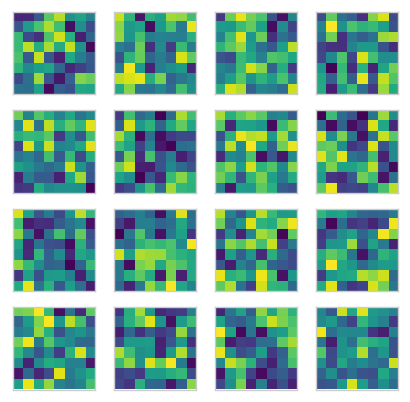

In [58]:
torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
x = grab(torch_x)
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
  for j in range(4):
    ind = i*4 + j
    ax[i,j].imshow(np.tanh(x[ind]), vmin=-1, vmax=1, cmap='viridis')
    ax[i,j].axes.xaxis.set_visible(False)
    ax[i,j].axes.yaxis.set_visible(False)
plt.show()

slope 1 linear regression S = S_eff + 723.3511


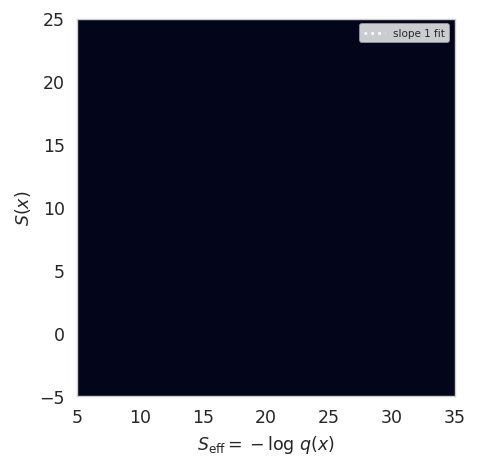

In [59]:
S_eff = -grab(torch_logq)
S = grab(phi4_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[5, 35], [-5, 25]])
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(5, 35, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
plt.legend(prop={'size': 6})
plt.show()